# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from sklearn import mixture
import seaborn as sns; sns.set()

Load feature names.

In [4]:
feature_names = []
with open('./mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open('./mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

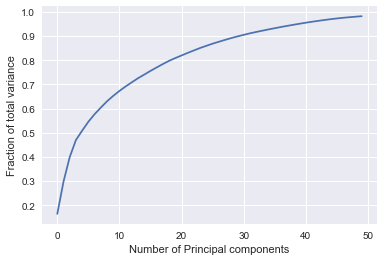

k= 1  Fraction of total variance: 0.164043312793
k= 2  Fraction of total variance: 0.297278101488
k= 3  Fraction of total variance: 0.399012666709
k= 4  Fraction of total variance: 0.469646231043
k= 5  Fraction of total variance: 0.508312680571
k= 6  Fraction of total variance: 0.545120734746
k= 7  Fraction of total variance: 0.576403080315
k= 8  Fraction of total variance: 0.603740263764
k= 9  Fraction of total variance: 0.629905226249
k= 10  Fraction of total variance: 0.652209195243
k= 11  Fraction of total variance: 0.672691707776
k= 12  Fraction of total variance: 0.691377512699
k= 13  Fraction of total variance: 0.708569477696
k= 14  Fraction of total variance: 0.725480347688
k= 15  Fraction of total variance: 0.740454789208
k= 16  Fraction of total variance: 0.755732427921
k= 17  Fraction of total variance: 0.770026879132
k= 18  Fraction of total variance: 0.784156812806
k= 19  Fraction of total variance: 0.797395633183
k= 20  Fraction of total variance: 0.808887328495
k= 21  Fr

In [62]:
def P1():
    # PCA for k in [1, 50] 
    variance_frac_list = list()
    for k in range(1,51):
        pca = PCA(n_components=k)
        pca.fit(train_data)
        variance_frac_list.append(np.sum(pca.explained_variance_ratio_))

    plt.figure()
    plt.plot(variance_frac_list)
    plt.xlabel('Number of Principal components')
    plt.ylabel('Fraction of total variance')
    plt.show()

    for k in range(50):
        print('k=',k+1, ' Fraction of total variance:', variance_frac_list[k])

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

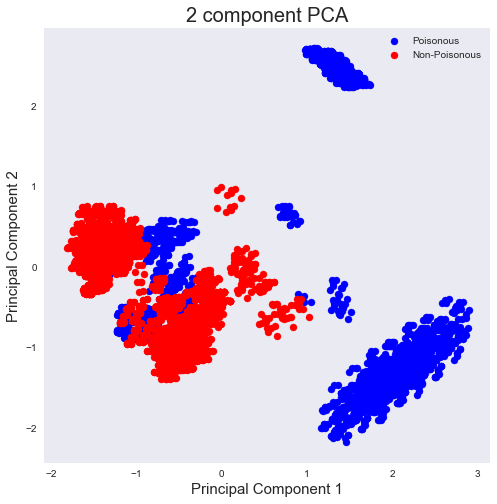

In [17]:
def P2():
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(train_data)
    pcaDF = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    pcaDF['Target'] = train_labels
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    target_names = ['Poisonous', 'Non-Poisonous']
    targets = [1,0]
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        match_indexes = (pcaDF['Target'] == target)
        ax.scatter(pcaDF.loc[match_indexes, 'pc1']
                   , pcaDF.loc[match_indexes, 'pc2']
                   , c = color
                   , s = 50)
    ax.legend(target_names)
    ax.grid()
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

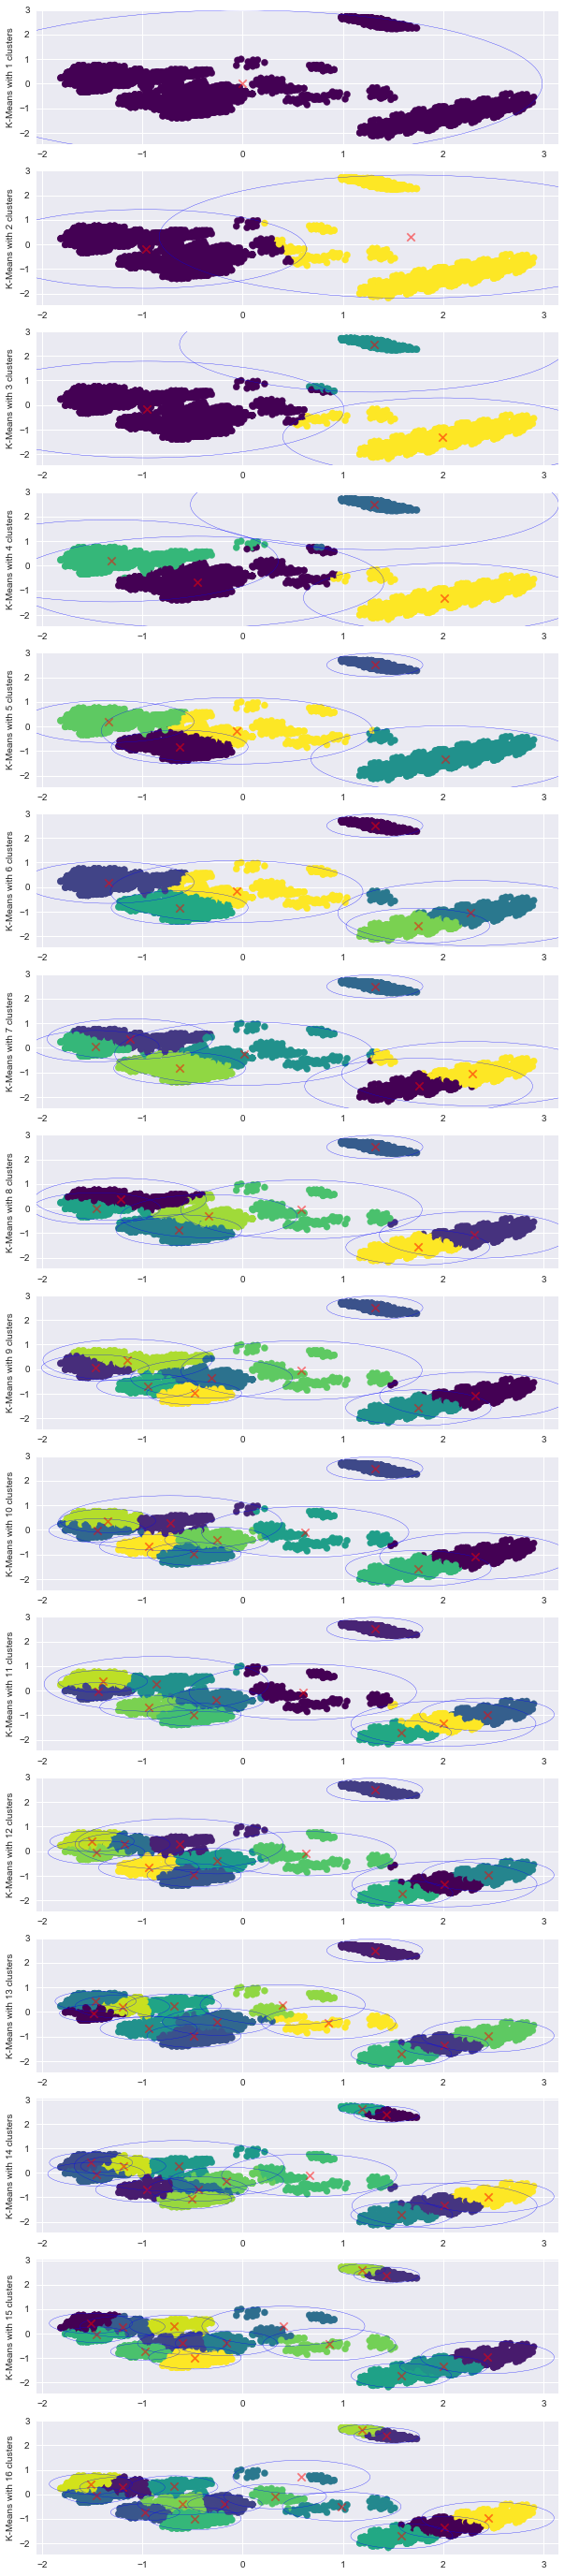

In [48]:
def P3():
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(train_data)
    pcaDF = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    figure = plt.figure(figsize=(10,50))
    # Loop through clusters [1:16]
    for i in range(16):
        # Empty list to store the max distance from each centroid
        max_points = list()
        kmeans = KMeans(n_clusters=i+1, random_state=0)
        kmeans.fit(principalComponents)
        distances = kmeans.transform(principalComponents)
        pred_kmeans = kmeans.predict(principalComponents)
        for index in range(i+1):
            cluster_points = kmeans.labels_ == index
            clusterdist = distances[cluster_points]
            max_points.append(np.max(clusterdist[:,index]))    
        ax = plt.subplot2grid((16,1),(i,0),rowspan=1,colspan=1)
        # ax.axis is needed to display circle instead of a stretched eliptical shape
        # However, the picture is too small for my liking. Hence sticking with stretched output.
        #ax.axis('equal')
        ax.set_ylabel('K-Means with {} clusters'.format(i+1), fontsize = 10)
        ax.scatter(pcaDF['pc1'], pcaDF['pc2'], c=pred_kmeans, s=50, cmap='viridis')
        #ax.set_xbound(lower=-3, upper=3)
        centers = kmeans.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=70, alpha=0.5);
        for index in range(i+1):
            centroid = centers[index]
            # Plot a circle with centroid as center and radius as distance to farthest point of the centroid
            ax.add_artist(plt.Circle((centroid[0],centroid[1]),max_points[index],color='b',fill=False))
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/Users/kurapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kurapati/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


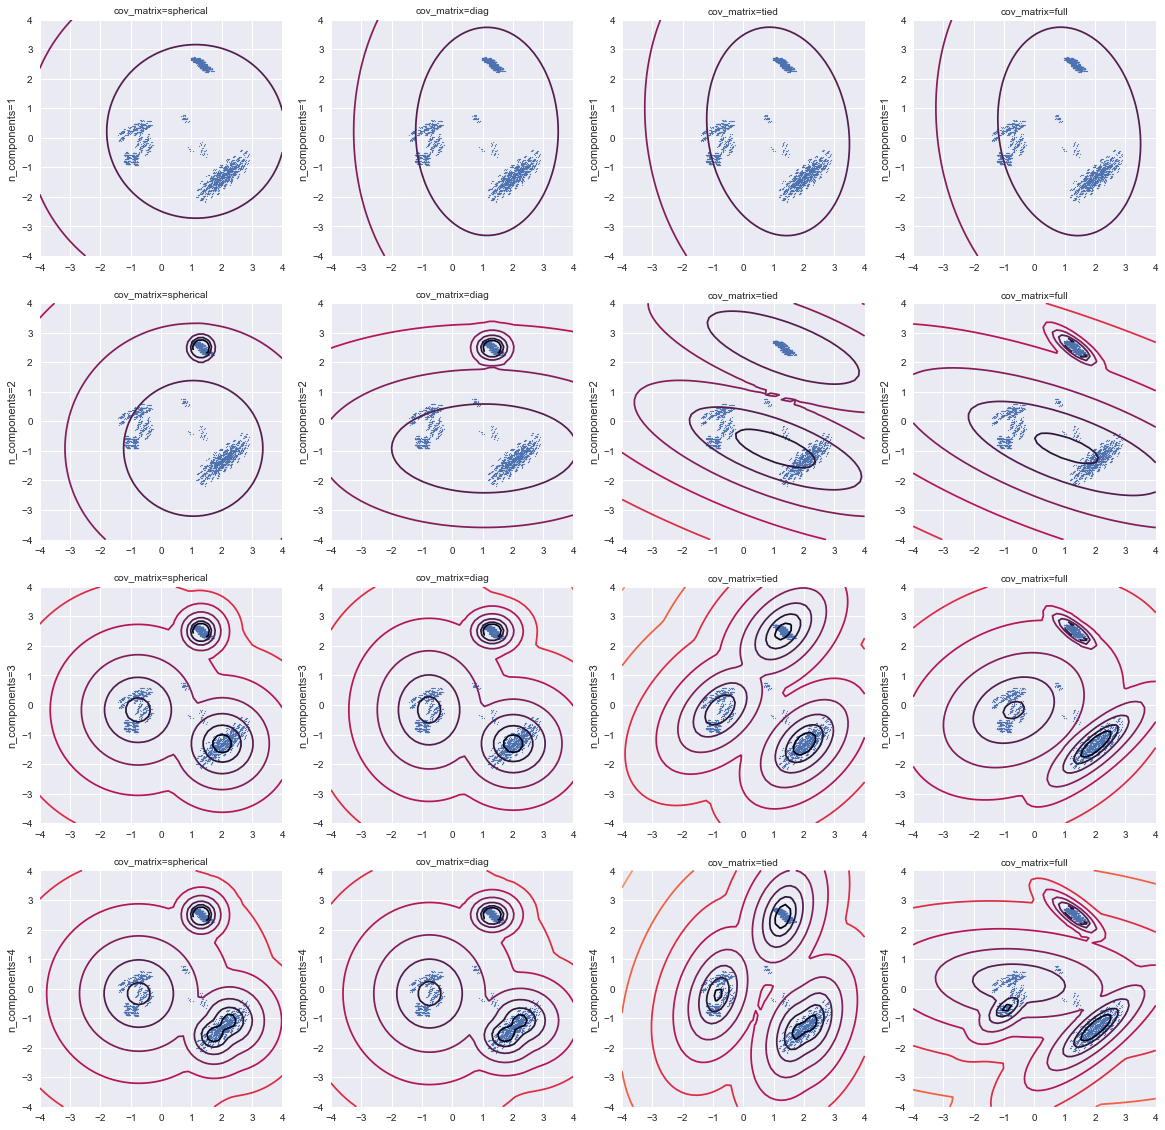

In [25]:
# 2 component PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_data)

# Create a pandas dataframe
pcaDF = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
pcaDF['Target'] = train_labels

# Take only positive examples as asked by the problem
pcaDF_positive = pcaDF[pcaDF['Target']==1]
pcaDF_positive.drop('Target',axis=1,inplace=True)
pca_positive = pcaDF_positive.as_matrix(columns=None)

cov_matrix_list = ['spherical', 'diag', 'tied', 'full']
n_components_list = list(range(1,5))
figure = plt.figure(figsize=(20,20))

# Outer loop for number of components
for i in range(4):
    # Inner loop for covariance matrix
    for j in range(4): 
        clf = mixture.GaussianMixture(n_components=n_components_list[i], covariance_type=cov_matrix_list[j])
        clf.fit(pca_positive)
        #clf.fit(principalComponents)
        x = np.linspace(-4,4)
        y = np.linspace(-4,4)
        Xm, Ym = np.meshgrid(x, y)
        XX = np.array([Xm.ravel(), Ym.ravel()]).T
        Zm = -clf.score_samples(XX)
        Zm = Zm.reshape(Xm.shape)
        ax = plt.subplot2grid((4,4),(i,j),rowspan=1,colspan=1)
        ax.set_ylabel('n_components={}'.format(n_components_list[i]))
        ax.set_title('cov_matrix={}'.format(cov_matrix_list[j]), fontsize = 10)
        CS = ax.contour(Xm, Ym, Zm, norm=LogNorm(vmin=1.0, vmax=1000.0),
                         levels=np.logspace(0, 3, 10))
        ax.scatter(pcaDF_positive['pc1'], pcaDF_positive['pc2'], .8)

plt.show()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [61]:
# 2 component PCA
pca = PCA(n_components=2)
pca.fit(train_data)
principalComponents = pca.transform(train_data)
#Tranform test data with same pca
pca_test = pca.transform(test_data)

# Create a pandas dataframe
pcaDF = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
pcaDF['Target'] = train_labels

# Separate the positive examples as asked by the problem
pcaDF_positive = pcaDF[pcaDF['Target']==1]
pcaDF_negative = pcaDF[pcaDF['Target']==0]
pcaDF_positive.drop('Target',axis=1,inplace=True)
pcaDF_negative.drop('Target',axis=1,inplace=True)

# Convert back to numpy
pca_positive = pcaDF_positive.as_matrix(columns=None)
pca_negative = pcaDF_negative.as_matrix(columns=None)

# 4 component GMM for positive examples
clf_positive = mixture.GaussianMixture(n_components=4, covariance_type="full")
clf_positive.fit(pca_positive)

# 4 component GMM for negative examples
clf_negative = mixture.GaussianMixture(n_components=4, covariance_type="full")
clf_negative.fit(pca_negative)

# Log likelihood for positive data
positive_ll = clf_positive.score_samples(pca_test)

# Log likelihood for negative data
negative_ll = clf_negative.score_samples(pca_test)

test_pred = list()
# Loop through both the results and select the model that has max log likelihood
for i in range(np.shape(positive_ll)[0]):
    if(positive_ll[i]>negative_ll[i]):
        test_pred.append(1)
    else:
        test_pred.append(0)

accuracy = np.mean(np.array(test_pred)==test_labels)
print("Accuracy is: ",accuracy)
    

Accuracy is:  0.950177935943


/Users/kurapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/kurapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [60]:
def number_of_parameters(num_pca, num_gmm, cov_type, num_classes=2):
    # Most of this work is derived from http://trace.tennessee.edu/cgi/viewcontent.cgi?article=2096&context=utk_gradthes
    # We will consider the models where volume is not varied between the GMM components.
    
    # Define general variables as per the formula:
    K = num_gmm
    p = num_pca
    alpha = K*p + K - 1
    beta = p*(p+1)/2
     
    if cov_type == 'spherical':
        # This is a diagonal Matrix with equal diagonal elements
        # The volume of the diagonal does not vary between each GMM component
        # Number of parameters is alpha + 1, which also expands to ((num_pca + 1)*num_gmm)*num_classes upon substitution
        num_parameters = (alpha + 1)*num_classes
    elif cov_type == 'diag':
        # This is a diagonal Matrix with diagnoal elements varying. Shape of the clusters vary but not the volume.
        # Number of parameters is alpha+K*p+1 which expands to (2*num_pca)*num_gmm*num_classes
        num_parameters = (alpha + (K*p) - K + 1)*num_classes
    elif cov_type == 'full':
        # This is a full representation where orientation and shape vary among equal volume clusters
        num_parameters = (alpha + K*beta - (K-1))*num_classes
    elif cov_type == 'tied':
        # This is a special model where a single covariance matrix is choosen among multiple models.
        num_parameters = ((K*p) + beta)*num_classes

    return num_parameters

cov_matrix_list = ['spherical', 'diag', 'tied', 'full']
pca_components_list = list(range(2,11))
gmm_components_list = list(range(2,11))

# Create a pandas data frame that stores all the variables

df_columns = ['pca_n_components','gmm_n_components','cov_matrix_type','total_params','accuracy']
df1 = pd.DataFrame(columns=df_columns)

for n_pca in pca_components_list:
    # This is the outer loop for PCA n_components
    pca = PCA(n_components=n_pca)
    pca.fit(train_data)
    principalComponents = pca.transform(train_data)
    #Tranform test data with same pca
    pca_test = pca.transform(test_data)

    # Create a pandas dataframe
    pcaDF = pd.DataFrame(data = principalComponents)
    pcaDF['Target'] = train_labels

    # Separate the positive examples as asked by the problem
    pcaDF_positive = pcaDF[pcaDF['Target']==1]
    pcaDF_negative = pcaDF[pcaDF['Target']==0]
    pcaDF_positive.drop('Target',axis=1,inplace=True)
    pcaDF_negative.drop('Target',axis=1,inplace=True)

    # Convert back to numpy
    pca_positive = pcaDF_positive.as_matrix(columns=None)
    pca_negative = pcaDF_negative.as_matrix(columns=None)
    
    # Start the Index 0
    Index = 0
    # Inner loop for Number of GMM
    for n_gmm in gmm_components_list:
        for cov_matrix in cov_matrix_list:
            # Check if number of parameters are higher than 50
            n_param = number_of_parameters(n_pca, n_gmm, cov_matrix)
            
            if(n_param>50):
                continue
                
            # GMM for positive data
            clf_positive = mixture.GaussianMixture(n_components=n_gmm, covariance_type=cov_matrix)
            clf_positive.fit(pca_positive)

            # GMM for negative data
            clf_negative = mixture.GaussianMixture(n_components=n_gmm, covariance_type=cov_matrix)
            clf_negative.fit(pca_negative)
            
            # Log likelihood for positive data
            positive_ll = clf_positive.score_samples(pca_test)

            # Log likelihood for negative data
            negative_ll = clf_negative.score_samples(pca_test)

            test_pred = list()
            # Loop through both the results and select the model that has max log likelihood
            for i in range(np.shape(positive_ll)[0]):
                if(positive_ll[i]>negative_ll[i]):
                    test_pred.append(1)
                else:
                    test_pred.append(0)

            accuracy = np.mean(np.array(test_pred)==test_labels)
            df1.loc[Index] = [n_pca,n_gmm,cov_matrix,n_param,accuracy]
            Index+=1

print(df1)
print("\nThe best accuracy is achieved by the below: ")
df1.loc[df1['accuracy'].idxmax()]            


/Users/kurapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kurapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   pca_n_components gmm_n_components cov_matrix_type total_params  accuracy
0                10                2       spherical           44  0.873665
1                 7                3       spherical           48  0.973310
2                 6                3       spherical           42  0.974199
3                 5                3       spherical           36  0.966192
4                 5                4       spherical           48  0.967972
5                 4                3            tied           44  0.969751
6                 4                4       spherical           40  0.957295
7                 4                5       spherical           50  0.953737
8                 3                4            diag           48  0.953737
9                 3                4            tied           36  0.950178
10                3                5       spherical           40  0.959964
11                3                5            tied           42  0.951068
12          

pca_n_components            6
gmm_n_components            3
cov_matrix_type     spherical
total_params               42
accuracy             0.974199
Name: 2, dtype: object